In [1]:
import pandas as pd
import numpy as np
import os
import gget
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy

sys.path.append("../")

import utils as ut

In [2]:
%matplotlib inline

In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/cleanData/"

clusters = {}

for f in os.listdir(dirPath):
    
    if "clusters" in f:
        key = f.split("_")[0]
        fullPath = f"{dirPath}{f}"
        df = pd.read_parquet(fullPath)
        df['cellId'] = df['cellId'].str.replace('-', ".")
        df['key'] = key
        clusters[key] = df
        print(f, key, df.shape)
        
print('done')

HFD14_clusters.pq HFD14 (6436, 4)
HFD8_clusters.pq HFD8 (6123, 4)
ND_clusters.pq ND (1261, 4)
done


In [4]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [5]:
# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
mf = ut.read_panglaodb(pandPath)

print(pd.DataFrame(mf['cell type'].value_counts()))

def querymf(mf, ctype):
    q = mf[mf['cell type'] == ctype]
    return q

def querycelltype(mf, q):
    return [x for x in mf['cell type'].unique() if q in x.lower()]

mf.head()

                                        count
cell type                                    
Interneurons                              221
Neurons                                   211
Endothelial cells                         195
Fibroblasts                               179
Germ cells                                170
...                                       ...
His bundle cells                            3
Glycinergic neurons                         2
Pulmonary vascular smooth muscle cells      2
Oxyphil cells                               2
Trophoblast stem cells                      1

[178 rows x 1 columns]


,species,official gene symbol,cell type,nicknames,ubiquitousness index,product description,gene type,canonical marker,germ layer,organ,sensitivity_human,sensitivity_mouse,specificity_human,specificity_mouse,gene
0,Mm Hs,CTRB1,Acinar cells,CTRB,0.017,chymotrypsinogen B1,protein-coding gene,1.0,Endoderm,Pancreas,1.000000,0.957143,0.000629,0.015920,CTRB1
1,Mm Hs,KLK1,Acinar cells,Klk6,0.013,kallikrein 1,protein-coding gene,1.0,Endoderm,Pancreas,0.833333,0.314286,0.005031,0.012826,KLK1
2,Mm Hs,RBPJL,Acinar cells,RBP-L|SUHL|RBPSUHL,0.001,recombination signal binding protein for immun...,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.000000,0.000000,0.000000,RBPJL
3,Mm Hs,PTF1A,Acinar cells,PTF1-p48|bHLHa29,0.001,pancreas associated transcription factor 1a,protein-coding gene,1.0,Endoderm,Pancreas,0.000000,0.157143,0.000629,0.000773,PTF1A
4,Mm,TRY4,Acinar cells,NaN,0.007,trypsin 4,protein coding gene,1.0,Endoderm,Pancreas,NaN,NaN,NaN,NaN,TRY4


In [6]:
subtypes = [
 'B cells',
 'B cells memory',
 'B cells naive',
 'Dendritic cells',
 'Gamma delta T cells',
 'Macrophages',
 'Mast cells',
 'Monocytes',
 'Myeloid-derived suppressor cells',
 'Natural killer T cells',
 'NK cells',
 'Plasmacytoid dendritic cells',
 'T cells',
 'T cells naive',
 'T cytotoxic cells',
 'T follicular helper cells',
 'T helper cells',
 'T memory cells',
 'T regulatory cells',
]

In [7]:
# genes = ['TCF4', 'RELB', 'WDFY4', 'IRF8', 'TRIM35', 'CST3', 'DPP4', 'LY75', 'PBX1', 'MGL2', 'KMO', 'ZBTB46', 'SELL', 'NUDT17', 'BST2', 'CADM1', 'CD81', 'LY6C1', 'FABP5', 'S100A4', 'CD8A', 'SPINT2', 'SIRPA', 'IL12B', 'ITGAM', 'CX3CR1', 'SEPT3', 'FOXP3', 'IL4I1', 'CCR7', 'KLRD1', 'CCL17', 'CCR2', 'BATF3', 'CD24A', 'FH1', 'LY6C2', 'RAMP3', 'CD4', 'CFP', 'CD300A', 'XCR1', 'GCSAM', 'CD7', 'ITGAE', 'AHR', 'FLT3', 'CLEC9A', 'SIGLECH', 'CCR9', 'CDC42EP3', 'NCOA7', 'CD36', 'LYZ1', 'LYZ2', 'MPEG1', 'KLRB1B']

# genes = list(set([x.upper() for x in genes]))
# print(len(genes))

In [8]:
genes = list(mf[mf['cell type'].isin(subtypes)]['gene'].unique())

# make sure that these are expressed
rx = rna['ND'].columns
genes = [x for x in genes if x in rx]

print(len(genes))

803


In [9]:
# merge all expression
rdf = []
for key in keys:
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rf = rf[genes]
    rdf.append(rf)

rdf = pd.concat(rdf)
print(f"{rdf.shape=}")
rdf.head()

rdf.shape=(13820, 803)


Unnamed: 0,CD2,CD5,MS4A1,CR2,CD22,CD40,CD69,CD70,CD79A,CD79B,...,IKZF2,ENTPD1,CTLA4,IZUMO1R,CNGB1,TNFRSF18,IL1R1,ITGB8,LRRC32,FOLR1
cellId,,,,,,,,,,,,,,,,,,,,,
AAACGAACAGCAGTAG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,524.383849,0.0,...,0.0,524.383849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGAACGTCTACAGT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGAACTCCTCGCAT.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAGGGCGTTAGGGTG.1_ND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.994624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACAAAGAGTATAGGT.1_ND,99.532199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.532199,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
""" Build the reference dataframe """
ref = []
for key in keys:
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cdf = clusters[key]
    lf = pd.merge(lf, cdf[['cellId', 'clusterId']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId',)
    
    ref.append(lf)
    

ref = pd.concat(ref, ignore_index=True)
ref = ref.rename(columns={'sampleInfo' : 'key'})
ref['id'] = ref['cellId'] + "_" + ref['key']
print(f"{ref.shape=}")
ref.head()

ref.shape=(13820, 9)


,cellId,cellType,key,x,y,colors,metaTypes,clusterId,id
0,AAACGAACAGCAGTAG.1,B cells,ND,6.783486,1.839065,#9e0142,B cells,4,AAACGAACAGCAGTAG.1_ND
1,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,Macrophages,3,AAAGAACGTCTACAGT.1_ND
2,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,Macrophages,3,AAAGAACTCCTCGCAT.1_ND
3,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,Macrophages,1,AAAGGGCGTTAGGGTG.1_ND
4,AACAAAGAGTATAGGT.1,Monocytes,ND,3.178745,4.929769,#ffffbe,Monocytes,5,AACAAAGAGTATAGGT.1_ND


# T cells

In [11]:
ctype = "T cells"

subtype = [
    'T cells',
    'T cells naive',
    'T cytotoxic cells',
    # 'T follicular helper cells',
    # 'T helper cells',
    # 'T memory cells',
    'T regulatory cells',
]


# get T cells
mask = (ref['metaTypes'] == ctype)
cdf = ref[mask].reset_index()
cellIds = cdf['id'].to_list()

# get t cell gene expression
rx = rdf[rdf.index.isin(cellIds)]
print(f"{rx.shape=}")

# get the marker genes
stdf = mf[mf['cell type'].isin(subtype)]
print(f"{stdf.shape=}")
genes = stdf['gene'].unique()
print(f"{len(genes)=} (all)")
genes = [x for x in genes if x in rx.columns]
print(f"{len(genes)=} (expressed)")


# cluster the cells
k = 3
clustering = AgglomerativeClustering(n_clusters=k).fit(rx[genes])
# clustering = AgglomerativeClustering(n_clusters=k).fit(rx)
# clustering = SpectralClustering(n_clusters=k,
#                                 assign_labels='discretize',
#                                 random_state=0).fit(rx)

cdf['cluster'] = clustering.labels_ + 1
cdf['cluster'] = cdf['cluster'].apply(lambda x: f"T{x}")

# get differential expression of the markers
deg = []

for cid in cdf['cluster'].unique():
    inClusterIds = cdf[cdf['cluster'] == cid]['id'].to_list()
    
    mask = rx.index.isin(inClusterIds)
    inGroup = rx[mask]
    outGroup = rx[~mask]
    
    
    for g in rx.columns:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cluster" : cid,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
    
deg = pd.DataFrame(deg)
deg.head()

rx.shape=(1692, 803)
stdf.shape=(140, 15)
len(genes)=126 (all)
len(genes)=117 (expressed)


,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,T1,-7.176274,7.163672e-13,-0.939667,305.332456,0.491215,586.571897,0.634969
1,CD5,T1,0.763027,4.454474e-01,0.143511,110.621935,0.216691,100.052816,0.187117
2,MS4A1,T1,1.482338,1.382503e-01,2.002435,25.269992,0.062225,5.556423,0.009202
3,CR2,T1,0.308466,7.577280e-01,1.147591,1.215437,0.010981,0.000000,0.000000
4,CD22,T1,1.336685,1.813256e-01,3.196599,8.167947,0.047584,0.000000,0.000000


In [14]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "tcell_subslcuster_deg.csv"
deg.to_csv(f"{dirpath}{fname}", index=False)
deg.head()

,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,T1,-7.176274,7.163672e-13,-0.939667,305.332456,0.491215,586.571897,0.634969
1,CD5,T1,0.763027,4.454474e-01,0.143511,110.621935,0.216691,100.052816,0.187117
2,MS4A1,T1,1.482338,1.382503e-01,2.002435,25.269992,0.062225,5.556423,0.009202
3,CR2,T1,0.308466,7.577280e-01,1.147591,1.215437,0.010981,0.000000,0.000000
4,CD22,T1,1.336685,1.813256e-01,3.196599,8.167947,0.047584,0.000000,0.000000


In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

alpha=0.05 ntests=2409 2.129213296542254e-05


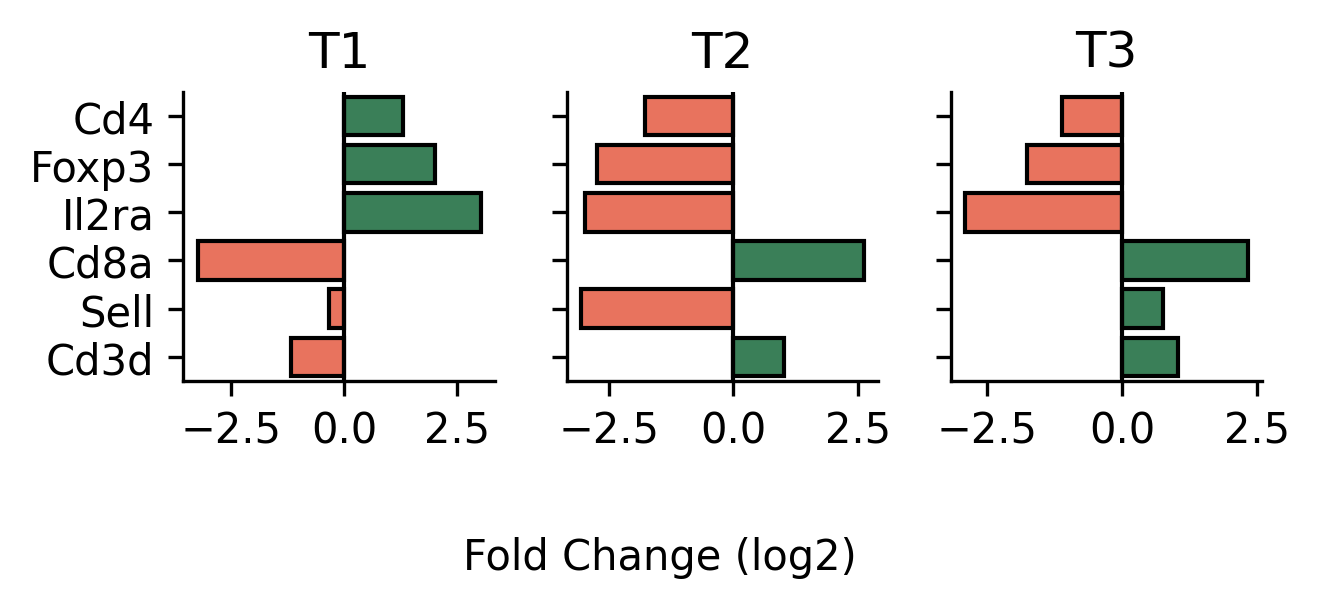

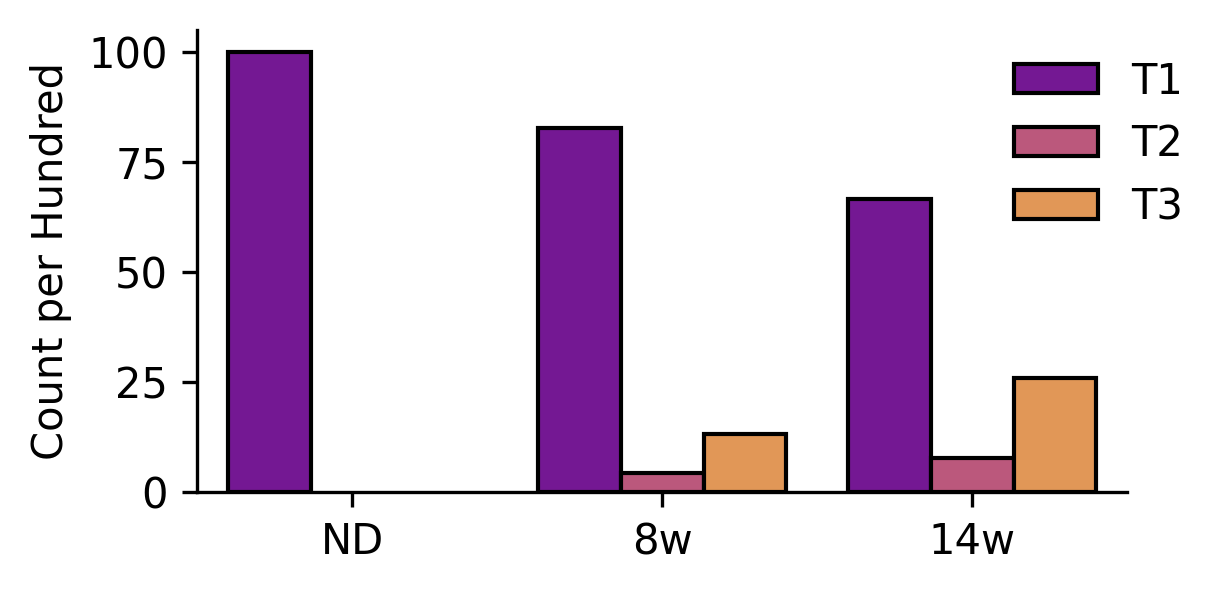

Unnamed: 0
CD4      0.148345
FOXP3    0.054374
IL2RA    0.210402
CD8A     0.144208
SELL     0.184397
CD3D     0.578605
dtype: float64


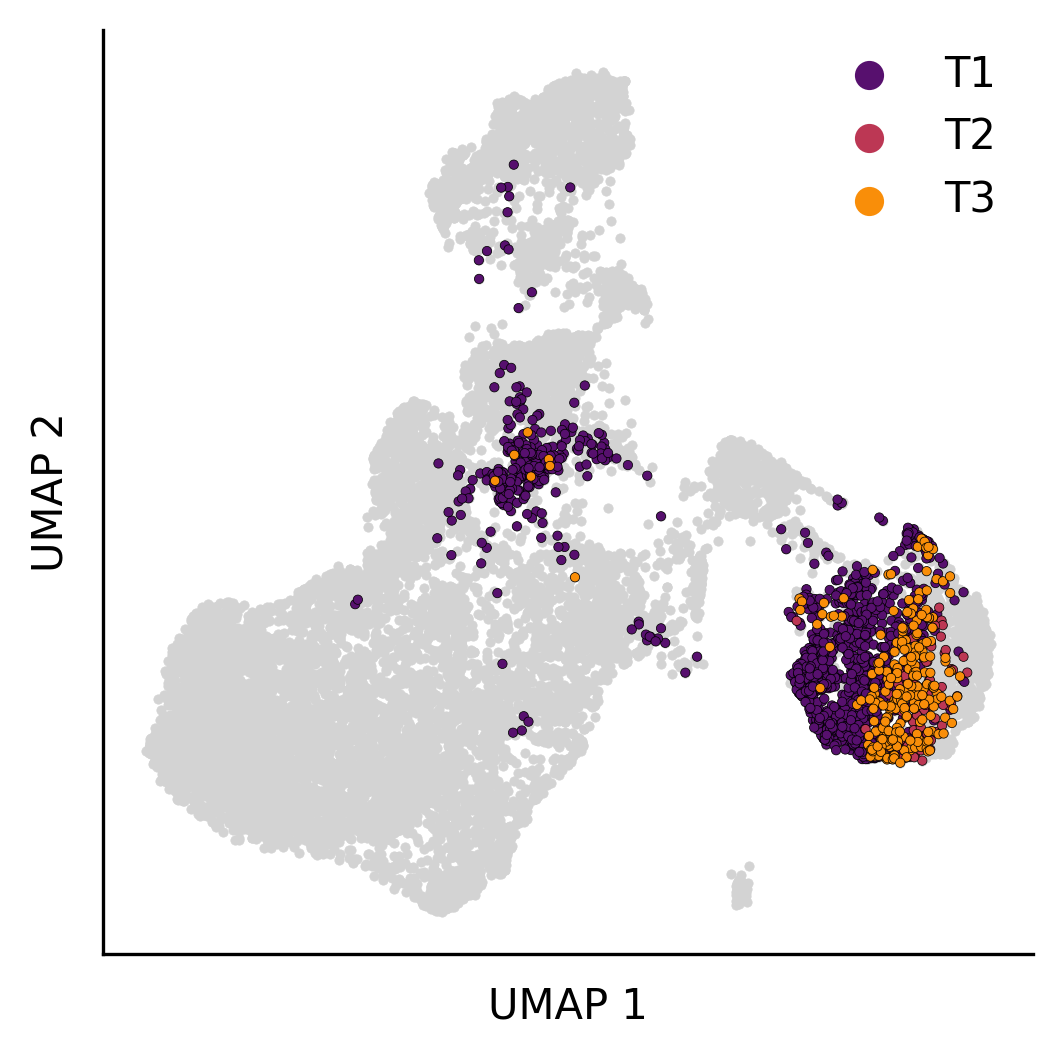

In [15]:
alpha = 0.05
ntests = len(deg)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdf = deg.copy()

# pdf = pdf[pdf['pval'] < alphaHat]
# pdf = pdf[(pdf['log2foldchange'].abs() > foldchange)]
"""
Plot Cluster Signatures
"""
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 2
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(1, k, sharey=True)
axs = axs.ravel()

plotGenes = ['CD4', 'FOXP3', 'IL2RA', 'CD8A', 'SELL', "CD3D"]

for i, clusterId in enumerate(sorted(deg['cluster'].unique())):
    cx = pdf[pdf['cluster'] == clusterId]
    
    cx = cx[cx['gene'].isin(plotGenes)]
    cx['geneName'] = cx['gene'].apply(lambda x: str(x).lower().capitalize())
    
    # sort by the user-defined order in plotGenes
    cx = cx.set_index('gene')
    cx = cx.reindex(plotGenes)
    cx = cx.reset_index(drop=False)

    colors = np.where(cx['log2foldchange'] < 0, "tomato", "seagreen")
    
    sns.barplot(data=cx, 
                x='log2foldchange',
                edgecolor='k',
                # hue='log2foldchange',
                palette=colors, # 
                # color='lightgrey',
                y='geneName',
                ax=axs[i])
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(clusterId)
    axs[i].axvline(x=0, lw=1, c='k')
    
fig.supxlabel("Fold Change (log2)", fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()


"""
Plot the changes over time
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2
plt.rcParams['figure.facecolor'] = "w"


cx = cdf[['key', 'cluster']].value_counts(normalize=False).reset_index()
cx.columns = ['key', 'cluster', 'count']
# cx['type'] = np.where(cx['cluster'] == 1, 'T Conventional', 'T Regulatory')
cx = cx.sort_values(by=['key', 'cluster'], ascending=[False, True])
cx['timeCount'] = cx.groupby('key')['count'].transform('sum')
cx['prop'] = (cx['count'] * 100) / cx['timeCount']

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

cx['keyName'] = cx['key'].map(keyMap)

sns.barplot(data=cx, 
            x='keyName',
            y='prop',
            edgecolor='k',
            hue='cluster',
            palette='plasma')

plt.ylabel("Count per Hundred")
plt.xlabel("")

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.1, 1.015),
                frameon=False,
                title="")

plt.show()


"""
PLOT THE EMBEDDING
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=ref, 
                x='x',
                y='y',
                s=5,
                color='lightgrey',
                ec='lightgrey',
                zorder=1)

pdf = cdf.sort_values(by='cluster')
sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                s=5,
                zorder=3,
                ec='k',
                palette='inferno',
                hue='cluster')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1, 1.015),
                frameon=False,
                title="")

plt.xticks([])
plt.yticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

t = rx[plotGenes].astype(bool).astype(int).sum(axis=0) / len(rx)
print(t)

In [ ]:
break

# Monocytes

In [16]:
ctype = "Monocytes"

subtype = [
    'Monocytes',
    # 'Macrophages',
]

# get cells
mask = (ref['metaTypes'] == ctype)
cdf = ref[mask].reset_index()
cellIds = cdf['id'].to_list()

# get cell gene expression
rx = rdf[rdf.index.isin(cellIds)]
print(f"{rx.shape=}")

# get the marker genes
stdf = mf[mf['cell type'].isin(subtype)]
print(f"{stdf.shape=}")
genes = stdf['gene'].unique()
print(f"{len(genes)=} (all)")
genes = [x for x in genes if x in rx.columns]
print(f"{len(genes)=} (expressed)")

# cluster the cells
k = 3
# clustering = AgglomerativeClustering(n_clusters=k).fit(rx[genes])
# clustering = AgglomerativeClustering(n_clusters=k).fit(rx)
# clustering = AgglomerativeClustering(n_clusters=k,
#                                      linkage='complete').fit(rx[genes])

clustering = SpectralClustering(n_clusters=k,
                                assign_labels='discretize',
                                random_state=0).fit(rx)


cdf['cluster'] = clustering.labels_ + 1
cdf['cluster'] = cdf['cluster'].apply(lambda x: f"MO{x}")

# get differential expression of the markers
deg = []

for cid in cdf['cluster'].unique():
    inClusterIds = cdf[cdf['cluster'] == cid]['id'].to_list()
    
    mask = rx.index.isin(inClusterIds)
    inGroup = rx[mask]
    outGroup = rx[~mask]
    
    
    for g in rx.columns:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cluster" : cid,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
    
deg = pd.DataFrame(deg)
deg.head()

rx.shape=(1899, 803)
stdf.shape=(102, 15)
len(genes)=102 (all)
len(genes)=85 (expressed)


,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,MO1,-0.163438,0.870173,0.073416,18.252398,0.042274,17.297190,0.046991
1,CD5,MO1,-0.028401,0.977342,-0.849324,1.327683,0.005831,3.193687,0.006595
2,MS4A1,MO1,-0.210484,0.833290,-0.492383,5.997322,0.013120,8.843601,0.018961
3,CR2,MO1,-0.006926,0.994474,-0.936976,0.347491,0.001458,1.579787,0.001649
4,CD22,MO1,-0.663293,0.507143,-1.826305,1.436183,0.001458,7.639377,0.019786


In [17]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "monocyte_subslcuster_deg.csv"
deg.to_csv(f"{dirpath}{fname}", index=False)
deg.head()

,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,MO1,-0.163438,0.870173,0.073416,18.252398,0.042274,17.297190,0.046991
1,CD5,MO1,-0.028401,0.977342,-0.849324,1.327683,0.005831,3.193687,0.006595
2,MS4A1,MO1,-0.210484,0.833290,-0.492383,5.997322,0.013120,8.843601,0.018961
3,CR2,MO1,-0.006926,0.994474,-0.936976,0.347491,0.001458,1.579787,0.001649
4,CD22,MO1,-0.663293,0.507143,-1.826305,1.436183,0.001458,7.639377,0.019786


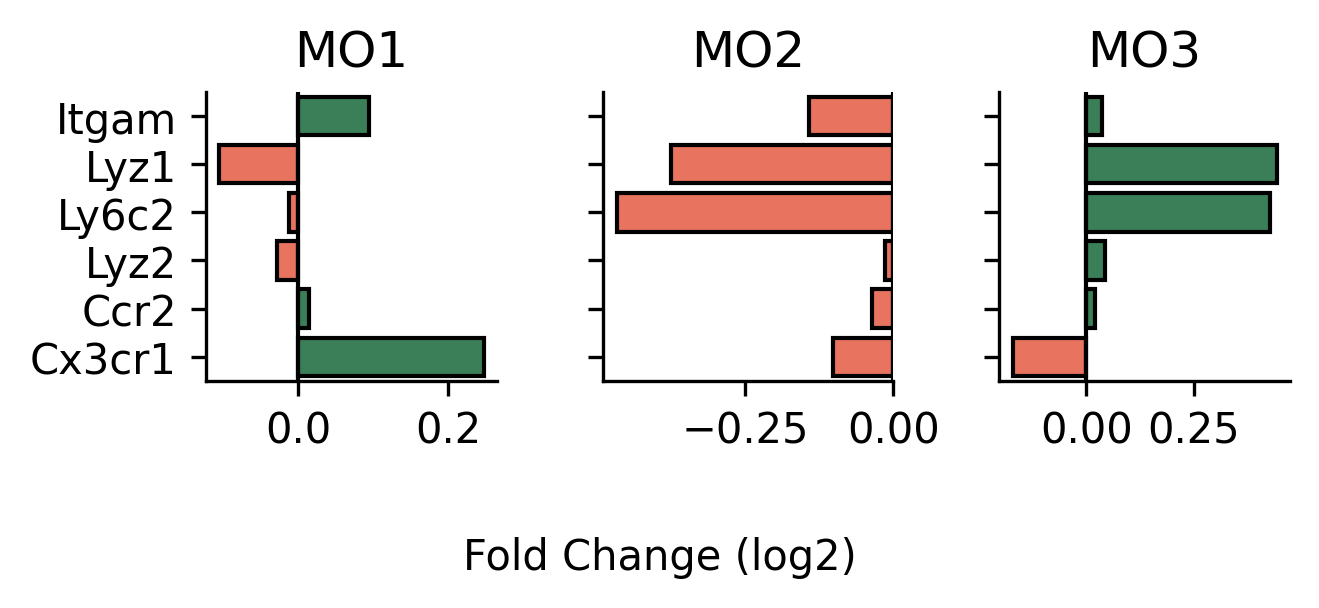

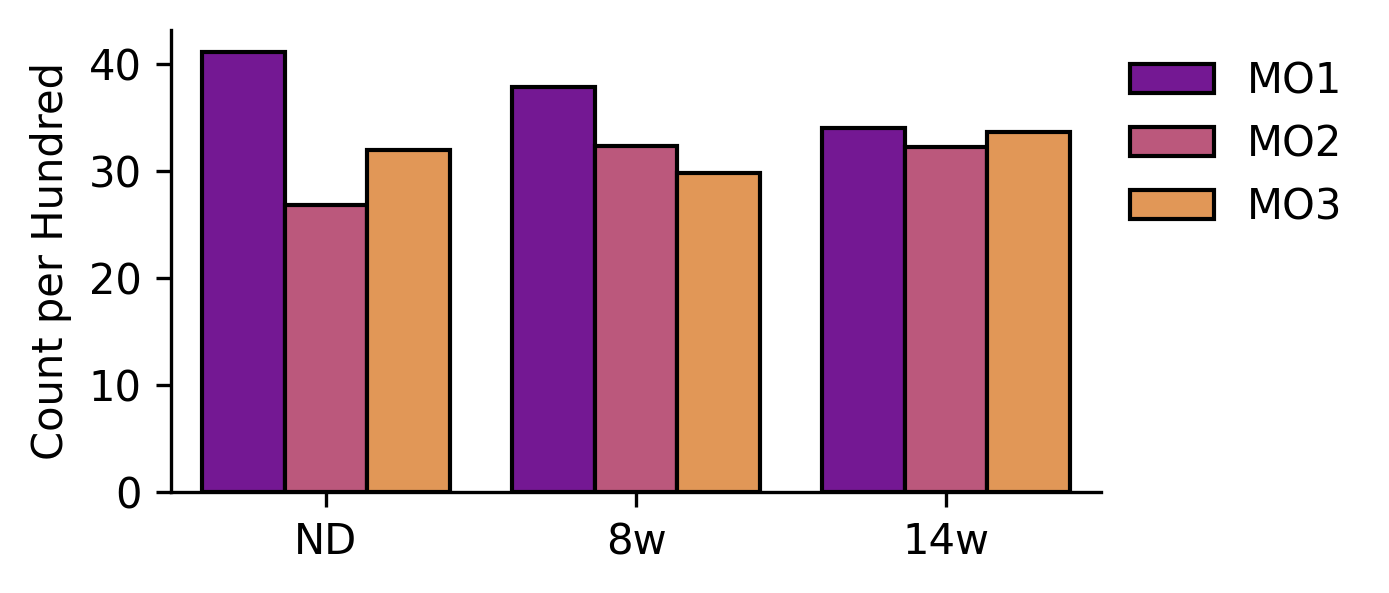

Unnamed: 0
ITGAM     0.466035
LYZ1      0.083728
LY6C2     0.163244
LYZ2      0.934176
CCR2      0.565034
CX3CR1    0.253291
dtype: float64


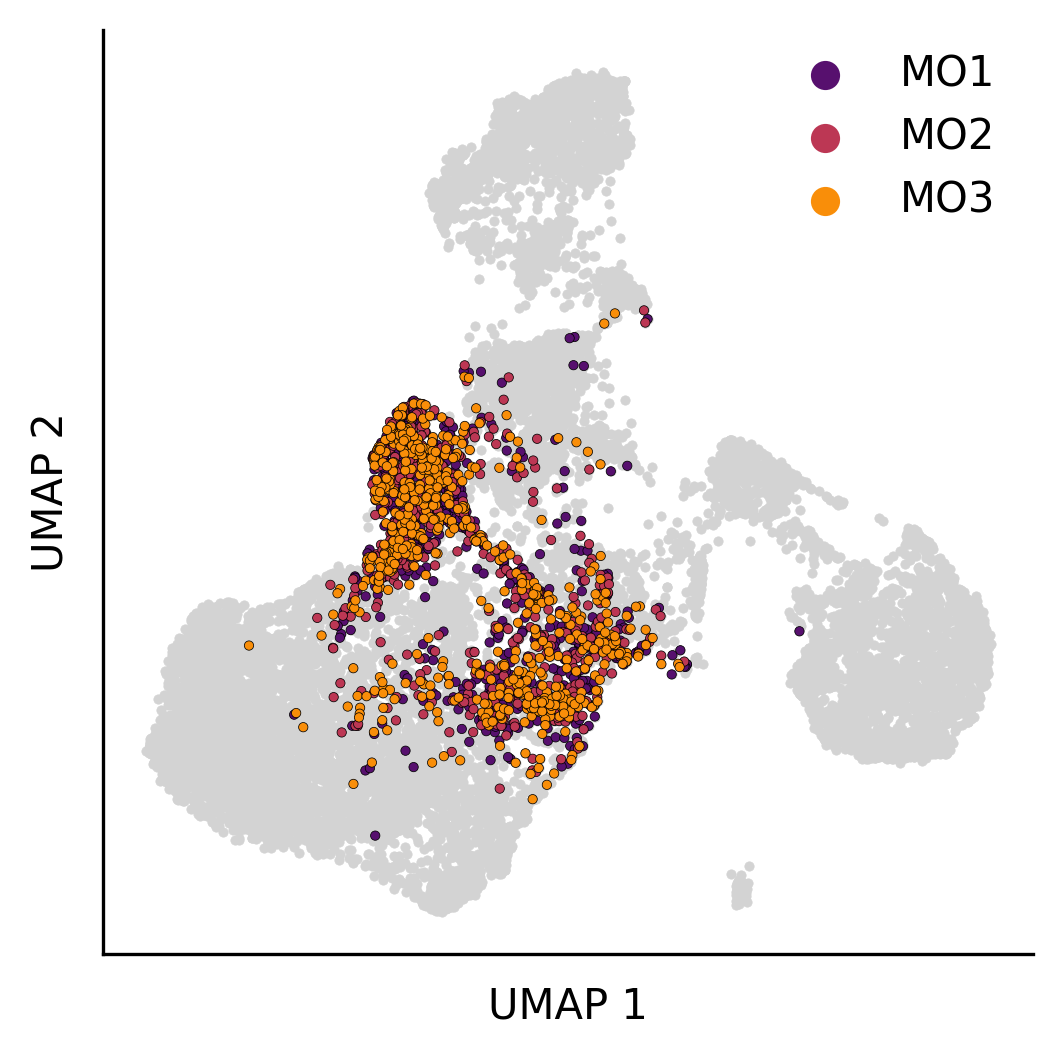

In [18]:
pdf = deg.copy()

# pdf = pdf[pdf['pval'] < alphaHat]
# pdf = pdf[(pdf['log2foldchange'].abs() > foldchange)]
"""
Plot Cluster Signatures
"""
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 2
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(1, k, sharey=True)
axs = axs.ravel()

plotGenes = [
             'ITGAM', 
             "Lyz1",
             'LY6C2', 
             "Lyz2",
             "Ccr2",
             'CX3CR1',
            ]

plotGenes = [x.upper() for x in plotGenes]

for i, clusterId in enumerate(sorted(deg['cluster'].unique())):
    cx = pdf[pdf['cluster'] == clusterId]
    
    cx = cx[cx['gene'].isin(plotGenes)]
    cx['geneName'] = cx['gene'].apply(lambda x: str(x).lower().capitalize())
    
    # sort by the user-defined order in plotGenes
    cx = cx.set_index('gene')
    cx = cx.reindex(plotGenes)
    cx = cx.reset_index(drop=False)
    
    colors = np.where(cx['log2foldchange'] < 0, "tomato", "seagreen")
    
    sns.barplot(data=cx, 
                x='log2foldchange',
                edgecolor='k',
                # hue='log2foldchange',
                palette=colors, # 
                # color='lightgrey',
                y='geneName',
                ax=axs[i])
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(clusterId)
    axs[i].axvline(x=0, lw=1, c='k')
    
fig.supxlabel("Fold Change (log2)", fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()

"""
Plot the changes over time
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2
plt.rcParams['figure.facecolor'] = "w"


cx = cdf[['key', 'cluster']].value_counts(normalize=False).reset_index()
cx.columns = ['key', 'cluster', 'count']
# cx['type'] = np.where(cx['cluster'] == 1, 'T Conventional', 'T Regulatory')
cx = cx.sort_values(by=['key', 'cluster'], ascending=[False, True])
cx['timeCount'] = cx.groupby('key')['count'].transform('sum')
cx['prop'] = (cx['count'] * 100) / cx['timeCount']

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

cx['keyName'] = cx['key'].map(keyMap)


sns.barplot(data=cx, 
            x='keyName',
            y='prop',
            edgecolor='k',
            hue='cluster',
            palette='plasma')

plt.ylabel("Count per Hundred")
plt.xlabel("")

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.3, 1.015),
                frameon=False,
                title="")

plt.show()

"""
PLOT THE EMBEDDING
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=ref, 
                x='x',
                y='y',
                s=5,
                color='lightgrey',
                ec='lightgrey',
                zorder=1)

pdf = cdf.sort_values(by='cluster')
sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                s=5,
                zorder=3,
                ec='k',
                palette='inferno',
                hue='cluster')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1, 1.015),
                frameon=False,
                title="")

plt.xticks([])
plt.yticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

# how many monocytes express each?
t = rx[plotGenes].astype(bool).astype(int).sum(axis=0) / len(rx)
print(t)

# Dendritic Cells

In [19]:
ctype = "Dendritic cells"

subtype = [
    'Dendritic cells',
    'Plasmacytoid dendritic cells',
]

# get T cells
mask = (ref['metaTypes'] == ctype)
cdf = ref[mask].reset_index()
cellIds = cdf['id'].to_list()

# get t cell gene expression
rx = rdf[rdf.index.isin(cellIds)]
print(f"{rx.shape=}")

# get the marker genes
stdf = mf[mf['cell type'].isin(subtype)]
print(f"{stdf.shape=}")
genes = stdf['gene'].unique()
print(f"{len(genes)=} (all)")
genes = [x for x in genes if x in rx.columns]
print(f"{len(genes)=} (expressed)")

# cluster the cells
k = 3
clustering = AgglomerativeClustering(n_clusters=k).fit(rx[genes])
# clustering = AgglomerativeClustering(n_clusters=k).fit(rx)
# clustering = AgglomerativeClustering(n_clusters=k).fit(rx)
# clustering = AgglomerativeClustering(n_clusters=k,
#                                      linkage='complete').fit(rx[genes])

# clustering = SpectralClustering(n_clusters=k,
#                                 assign_labels='discretize',
#                                 random_state=0).fit(rx)


cdf['cluster'] = clustering.labels_ + 1
cdf['cluster'] = cdf['cluster'].apply(lambda x: f"DC{x}")

# get differential expression of the markers
deg = []

for cid in cdf['cluster'].unique():
    inClusterIds = cdf[cdf['cluster'] == cid]['id'].to_list()
    
    mask = rx.index.isin(inClusterIds)
    inGroup = rx[mask]
    outGroup = rx[~mask]
    
    
    for g in rx.columns:
        score, pval = scipy.stats.ranksums(inGroup[g], outGroup[g],
                                           alternative='two-sided')

        lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

        row = {
            'gene' : g,
            "cluster" : cid,
            'score' : score,
            'pval' : pval,
            'log2foldchange' : lfc,
            'meanP1' : inGroup[g].mean(),
            'propP1' : inGroup[g].astype(bool).sum() / len(inGroup),
            'meanP2' : outGroup[g].mean(),
            'propP2' : outGroup[g].astype(bool).sum() / len(outGroup),
        }
        deg.append(row)
    
    
deg = pd.DataFrame(deg)
deg.head()

rx.shape=(2080, 803)
stdf.shape=(191, 15)
len(genes)=181 (all)
len(genes)=153 (expressed)


,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,DC2,5.475734,4.357012e-08,1.865445,47.832169,0.189121,12.401429,0.048588
1,CD5,DC2,1.795265,7.261146e-02,0.994487,11.031675,0.067782,5.038869,0.021469
2,MS4A1,DC2,0.800365,4.234992e-01,1.458858,9.115930,0.031799,2.679984,0.011299
3,CR2,DC2,0.326747,7.438589e-01,0.950192,0.932129,0.008368,0.000000,0.000000
4,CD22,DC2,0.920985,3.570583e-01,1.219916,5.335811,0.032636,1.720012,0.009040


In [20]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/SUPP/"
fname = "dendritic_cell_subslcuster_deg.csv"
deg.to_csv(f"{dirpath}{fname}", index=False)
deg.head()

,gene,cluster,score,pval,log2foldchange,meanP1,propP1,meanP2,propP2
0,CD2,DC2,5.475734,4.357012e-08,1.865445,47.832169,0.189121,12.401429,0.048588
1,CD5,DC2,1.795265,7.261146e-02,0.994487,11.031675,0.067782,5.038869,0.021469
2,MS4A1,DC2,0.800365,4.234992e-01,1.458858,9.115930,0.031799,2.679984,0.011299
3,CR2,DC2,0.326747,7.438589e-01,0.950192,0.932129,0.008368,0.000000,0.000000
4,CD22,DC2,0.920985,3.570583e-01,1.219916,5.335811,0.032636,1.720012,0.009040


(7, 11) 7
(7, 11) 7
(7, 11) 7


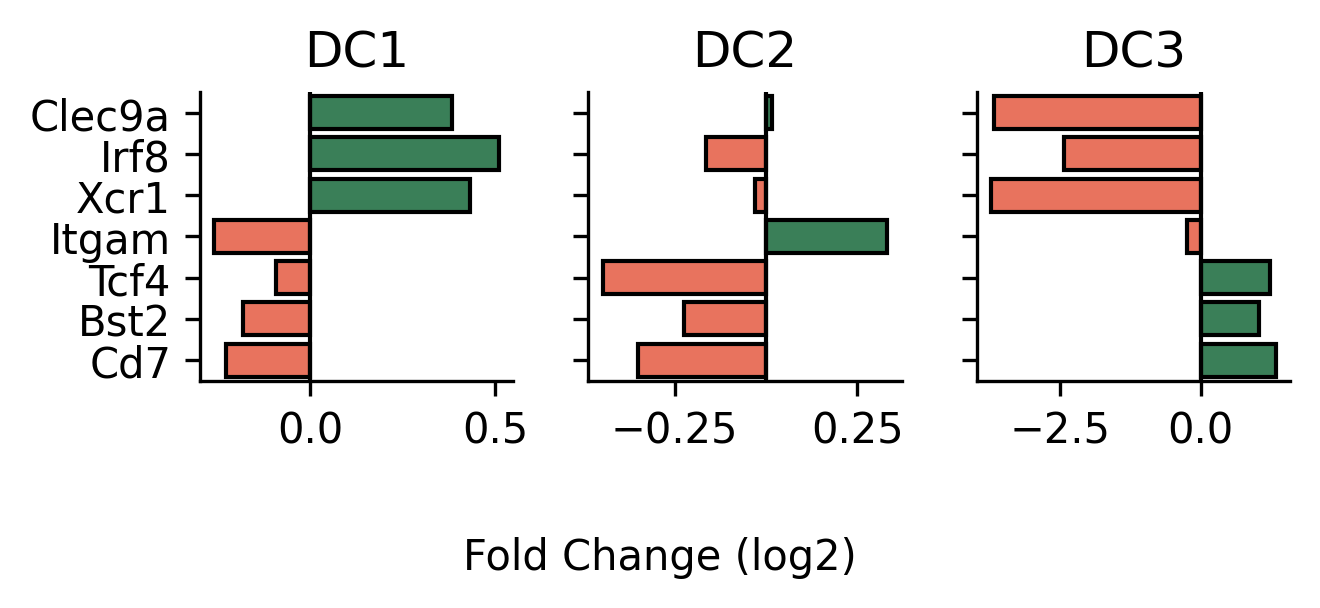

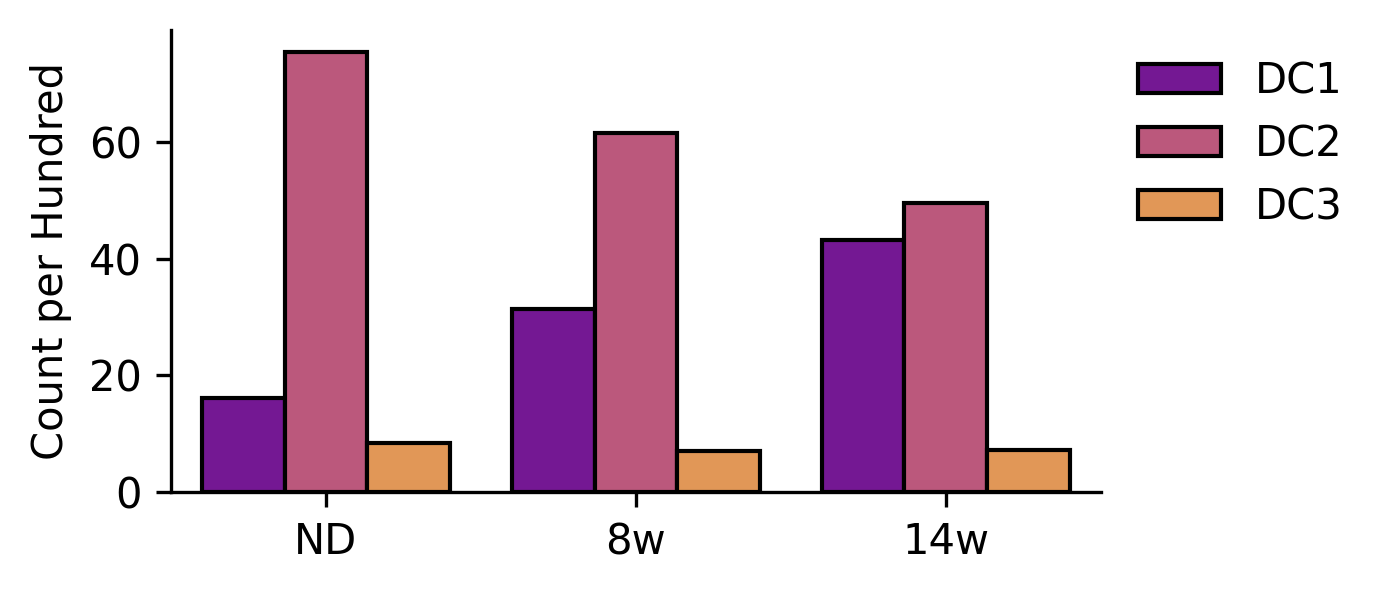

Unnamed: 0
CLEC9A    0.558173
IRF8      0.806731
XCR1      0.536538
ITGAM     0.115865
TCF4      0.206731
BST2      0.437981
CD7       0.079327
dtype: float64


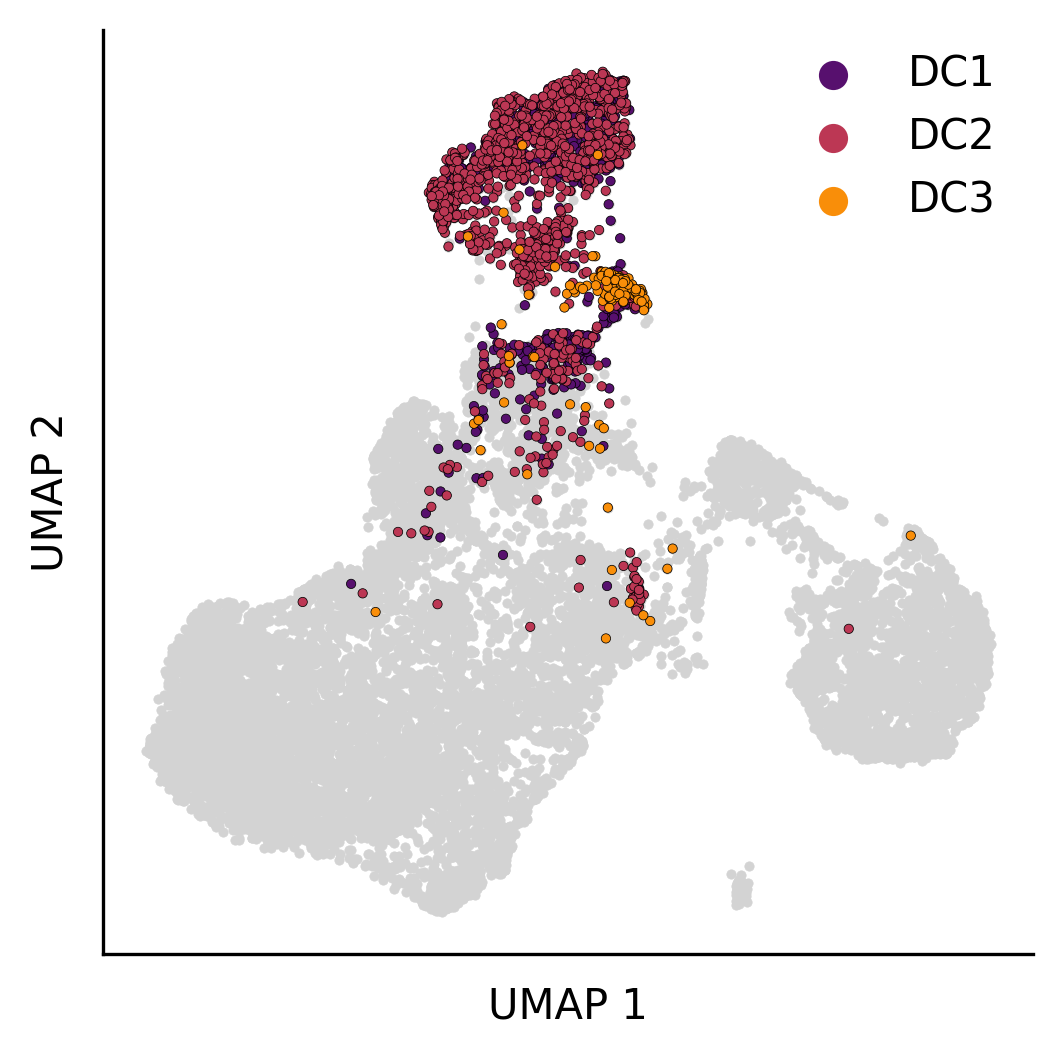

In [21]:
pdf = deg.copy()

dcMap = {
    "DC1" : "DC2",
    "DC2" : "DC1",
    "DC3" : "DC3",
}

pdf['cluster'] = pdf['cluster'].map(dcMap)

# pdf = pdf[pdf['pval'] < alphaHat]
# pdf = pdf[(pdf['log2foldchange'].abs() > foldchange)]
"""
Plot Cluster Signatures
"""
    
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 2
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(1, k, sharey=True)
axs = axs.ravel()

plotGenes = [
    "Clec9a",
    "Irf8",
    # "Itgae",
    "Xcr1",
    # "Cd4",
    "Itgam",
    # "Irf4",
    # "Ccr9",
    "Tcf4",
    "Bst2",
    "Cd7",
    # "Kmo",
    # "Klrd1",
]

plotGenes = [x.upper() for x in plotGenes]

for i, clusterId in enumerate(sorted(deg['cluster'].unique())):
    cx = pdf[pdf['cluster'] == clusterId].copy()
    
    cx = cx[cx['gene'].isin(plotGenes)].reset_index()
    cx['geneName'] = cx['gene'].apply(lambda x: str(x).lower().capitalize())
    
   # sort by the user-defined order in plotGenes
    
    cx = cx.set_index('gene')
    cx = cx.reindex(plotGenes)
    cx = cx.reset_index(drop=False)
    
    
    colors = np.where(cx['log2foldchange'] < 0, "tomato", "seagreen")
    
    print(cx.shape, len(colors))
    
    sns.barplot(data=cx, 
                x='log2foldchange',
                edgecolor='k',
                # hue='log2foldchange',
                palette=colors, # 
                # color='lightgrey',
                y='geneName',
                ax=axs[i])
    
    if i == 1:
        axs[i].set_xticks([-0.25, 0.25])
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(clusterId)
    axs[i].axvline(x=0, lw=1, c='k')
    
fig.supxlabel("Fold Change (log2)", fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()

"""
Plot the changes over time
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2
plt.rcParams['figure.facecolor'] = "w"


cx = cdf[['key', 'cluster']].value_counts(normalize=False).reset_index()
cx.columns = ['key', 'cluster', 'count']
# cx['type'] = np.where(cx['cluster'] == 1, 'T Conventional', 'T Regulatory')
cx = cx.sort_values(by=['key', 'cluster'], ascending=[False, True])
cx['timeCount'] = cx.groupby('key')['count'].transform('sum')
cx['prop'] = (cx['count'] * 100) / cx['timeCount']

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

cx['keyName'] = cx['key'].map(keyMap)


sns.barplot(data=cx, 
            x='keyName',
            y='prop',
            edgecolor='k',
            hue='cluster',
            palette='plasma')

plt.ylabel("Count per Hundred")
plt.xlabel("")

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.3, 1.015),
                frameon=False,
                title="")

plt.show()
"""
PLOT THE EMBEDDING
"""
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4
plt.rcParams['figure.facecolor'] = "w"

sns.scatterplot(data=ref, 
                x='x',
                y='y',
                s=5,
                color='lightgrey',
                ec='lightgrey',
                zorder=1)

pdf = cdf.sort_values(by='cluster')
sns.scatterplot(data=pdf, 
                x='x',
                y='y',
                s=5,
                zorder=3,
                ec='k',
                palette='inferno',
                hue='cluster')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1, 1.015),
                frameon=False,
                title="")

plt.xticks([])
plt.yticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

# how many DCs express each?
t = rx[plotGenes].astype(bool).astype(int).sum(axis=0) / len(rx)
print(t)

In [ ]:
querycelltype(mf, q='den')

In [ ]:
# # build the low-dimensional space, just in-case
# X = rdf.copy().astype(float)
# X = np.log1p(X) # X is the log-normalized expression of marker genes
# X = pd.DataFrame(X)
# X.index = rdf.index
# print(f"{X.shape=}")

# # compute the PCA 
# r = 30 # number of principal components
# pca = PCA(n_components=r)
# pcaModel = pca.fit(X)
# Xpca = pca.fit_transform(X)
# Xpca = pd.DataFrame(Xpca)
# Xpca.index = rdf.index
# print(f"{Xpca.shape=}")

In [ ]:
break

In [ ]:
testType = [
    # 'B cells',
    'Dendritic cells',
    # 'Macrophages',
    'Monocytes',
    # 'NK cells',
    'T cells'
]

nClust = {
    # 'B cells' : 2,
    'Dendritic cells' : 2,
    # 'Macrophages' : 5,
    'Monocytes' : 2,
    # 'NK cells' : 2,
    'T cells' : 3,
}


size = 7

res = []

for ctype in testType:
    
    mask = (ref['metaTypes'] == ctype)
    
    intype = ref[mask].reset_index()
    outtype = ref[~mask].reset_index()
    
    cellIds = intype['cellId'] + "_" + intype['key']
    cellIds = cellIds.to_list()
    
    k = nClust[ctype]
    print(f"{ctype} {len(cellIds)=} {k=}")
    
    Xclust = Xpca[Xpca.index.isin(cellIds)]
    
    clustering = AgglomerativeClustering(n_clusters=k).fit(Xclust)
    # clustering = DBSCAN().fit(Xclust)
    cids = clustering.labels_
    intype['cids'] = cids + 1
    intype = intype.sort_values(by='cids')
    intype['clusterLabel'] = intype['metaTypes'] + " " + intype['cids'].astype(str)
    
    
    """Add the results to a new dataframe """
    res.append(intype)
    
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 4,4
    plt.rcParams['figure.facecolor'] = "w"
    
    sns.scatterplot(data=intype,
                    x='x',
                    y='y',
                    s=size,
                    hue='clusterLabel',
                    palette='inferno',
                    ec='k',
                    zorder=3,)
    
    sns.scatterplot(data=outtype,
                    x='x',
                    y='y', 
                    s=size,
                    color='lightgrey',
                    ec='lightgrey',
                    zorder=1,)
    
    plt.ylabel("UMAP 2")
    plt.xlabel("UMAP 1")
    plt.xticks([])
    plt.yticks([])
    sns.despine()
    
    sns.move_legend(plt.gca(), 
                    loc='upper right',
                    bbox_to_anchor=(1.3, 1.015),
                    frameon=False,
                    title="")

    
    plt.show()    
    
    
res = pd.concat(res)
res.head()

In [ ]:

# genes = ['Ly6c2', 'Cx3cr1']
# genes = [x.upper() for x in genes]

# pdf = res.copy()
# pdf = pd.merge(pdf, 
#                rdf[genes], 
#                how='left',
#                left_on='id', 
#                right_index=True)


# mask = (pdf['metaTypes'] == 'Monocytes')
# pdf = pdf[mask]
# pdf[genes] = pdf[genes].astype(float)
# pdf[genes] = np.log1p(pdf[genes])

# pdf['sum'] = pdf[genes].sum(axis=1)
# # pdf = pdf[pdf['sum'] > 0] # drop cells that express neither

# pdf = pd.melt(pdf, 
#               id_vars=['key', 'id', 'clusterLabel'],
#               value_vars=genes)


# pdf['variable'] = pdf['variable'].apply(lambda x: str(x).lower().capitalize())
# pdf = pdf[pdf['value'] > 0]

# sns.boxplot(data=pdf, 
#             y='clusterLabel',
#             x='value',
#             showfliers=False,
#             palette='viridis',
#             hue='variable')

# sns.despine()
# sns.move_legend(plt.gca(), 
#                 loc='upper right',
#                 bbox_to_anchor=(1.3, 1.015),
#                 frameon=False,
#                 title="")

# plt.ylabel("")
# plt.xlabel("Expression (log)")
# # plt.xticks(rotation=90)

In [ ]:
testType = [
    'T cells'
]

for ctype in testType:
    mask = (ref['metaTypes'] == ctype)
    
    cdf = ref[mask].reset_index()
    
    cdf = pd.merge(cdf, rdf[['CD8A', 'CD4']].astype(float),
                   how='left',
                   left_on='id',
                   right_index=True)
    
    cdf['CD8A'] = np.log1p(cdf['CD8A'])
    cdf['CD4'] = np.log1p(cdf['CD4'])
    
    subtype = []
    t = 2
    for idx, row in cdf.iterrows():
        if row['CD8A'] > t:
            subtype.append('CD8')
        elif row['CD4'] > t:
            subtype.append('CD4')
        else:
            subtype.append('T Naive')

    cdf['subtype'] = subtype
    counts = cdf[['subtype', 'key']].value_counts().reset_index(drop=False)
    counts.columns = ['subtype', 'key', 'count']
    counts = counts.sort_values(by=['key', 'subtype'], ascending=[False, True])
    
    counts = counts[counts['subtype'] != 'T Naive']
        
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 3.5, 2
    plt.rcParams['figure.facecolor'] = "w"
    sns.barplot(data=counts, 
                x='key',
                y='count',
                hue='subtype', 
                edgecolor='k',
                palette='hot')
    
    sns.despine()
    sns.move_legend(plt.gca(), 
                loc='upper right',
                bbox_to_anchor=(1.3, 1.015),
                frameon=False,
                title="")
    plt.xlabel("")
    plt.ylabel("Number of cells")
    break